Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

采用logistic模型测试，不同的L2 regularization下分类效果的不同，采用的拟合batch size的大小为 128.

---

In [7]:
beta_val = np.logspace(-4, -2, 20)
batch_size = 128
accuracy_val = []

graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  beta_regul = tf.placeholder(tf.float32)
    
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)  
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [8]:
num_steps = 3001

for beta in beta_val:
    with tf.Session(graph=graph) as session:
        #tf.initialize_all_variables().run()
        tf.global_variables_initializer().run
        for step in range(num_steps):
            # offset 
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        print("L2 regularization(beta=%.5f) Test accuracy: %.1f%%" % (beta, accuracy(test_prediction.eval(), test_labels)))

        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 18.215281
Minibatch accuracy: 12.5%
Validation accuracy: 11.6%
Minibatch loss at step 500: 1.190510
Minibatch accuracy: 82.0%
Validation accuracy: 75.6%
Minibatch loss at step 1000: 1.480732
Minibatch accuracy: 76.6%
Validation accuracy: 77.2%
Minibatch loss at step 1500: 0.941327
Minibatch accuracy: 82.0%
Validation accuracy: 77.6%
Minibatch loss at step 2000: 0.857946
Minibatch accuracy: 82.0%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 1.034810
Minibatch accuracy: 75.0%
Validation accuracy: 78.7%
Minibatch loss at step 3000: 1.112719
Minibatch accuracy: 76.6%
Validation accuracy: 79.2%
L2 regularization(beta=0.00010) Test accuracy: 86.6%
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 19.517357
Minibatch accuracy: 7.8%
Validation accuracy: 8.6%
Minibatch loss at step 500: 1.244856
Minibatch accuracy: 82.8%
Validation accu

Best beta=0.002976, accuracy=89.1%


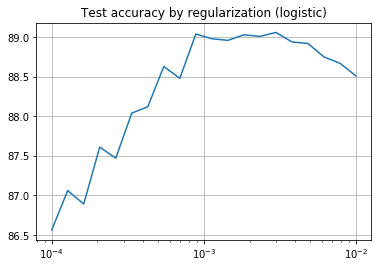

In [9]:
print('Best beta=%f, accuracy=%.1f%%' % (beta_val[np.argmax(accuracy_val)], max(accuracy_val)))
plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

可以看出当beta的值很小的时候发生了过拟合现象。然而如果beta的值过大，那么也会发生欠拟合。最佳值应该在10^-3附近。

下面采用NN模型

In [12]:
beta_val = np.logspace(-4, -2, 20)
batch_size = 128
accuracy_val = []

hidden_size = 1024
graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
  biases1 = tf.Variable(tf.zeros([hidden_size]))
  weights = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  beta_regul = tf.placeholder(tf.float32)
    
  # Training computation.
  y1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(y1, weights) + biases
  #loss = tf.reduce_mean(
  #      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)  
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  loss = loss + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) + tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))

    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  t = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(t, weights) + biases)
  t = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(t, weights) + biases)

In [15]:
num_steps = 3001

for beta in beta_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        #tf.global_variables_initializer().run
        for step in range(num_steps):
            # offset 
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        print("L2 regularization(beta=%.5f) Test accuracy: %.1f%%" % (beta, accuracy(test_prediction.eval(), test_labels)))

        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 447.537720
Minibatch accuracy: 9.4%
Validation accuracy: 28.5%
Minibatch loss at step 500: 42.269032
Minibatch accuracy: 87.5%
Validation accuracy: 78.9%
Minibatch loss at step 1000: 39.513084
Minibatch accuracy: 77.3%
Validation accuracy: 81.0%
Minibatch loss at step 1500: 31.666260
Minibatch accuracy: 89.1%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 27.818312
Minibatch accuracy: 82.8%
Validation accuracy: 81.3%
Minibatch loss at step 2500: 27.028563
Minibatch accuracy: 82.0%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 24.087461
Minibatch accuracy: 81.2%
Validation accuracy: 81.5%
L2 regularization(beta=0.00010) Test accuracy: 89.1%
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 423.547211
Minibatch accuracy: 4.7%
Validation accuracy: 30.3%
Minibatch loss at step 500: 62.978321
Minibatch accuracy: 80.5%
Valida

Best beta=0.001438, accuracy=93.3%


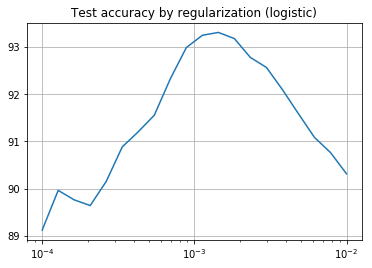

In [16]:
print('Best beta=%f, accuracy=%.1f%%' % (beta_val[np.argmax(accuracy_val)], max(accuracy_val)))
plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

类比上面图，这张图也是类似的趋势，但是最佳的拟合情况可以达到93.3%，相对前面来说大大的提高。其中采用了两个新的技术。首先采用了含有隐含层+relu的双层神经网络，同时在第一层的时候使用了Dropout技术。

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

这里要看看overfitting的结果。减少总体样本的数目，保持batch的大小来训练样本。这时候虽然采用了batch的方法，但是后期的训练的数据与前面使用的数据完全相同。有可能产生过拟合现象。

采用beta的值为0.001438，是上面拟合的最佳结果

---

In [18]:
# 采用一个正则化的值
beta = 0.001438
few_batch_size = batch_size * 5
small_train_dataset = train_dataset[:few_batch_size, :]
small_train_labels = train_labels[:few_batch_size, :]

print('Training set', small_train_dataset.shape, small_train_labels.shape)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: beta}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # print some message
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Overfitting with small dataset Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Training set (640, 784) (640, 10)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 805.833984
Minibatch accuracy: 6.2%
Validation accuracy: 19.8%
Minibatch loss at step 500: 219.908218
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 1000: 107.120148
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 1500: 52.179802
Minibatch accuracy: 100.0%
Validation accuracy: 74.8%
Minibatch loss at step 2000: 25.418415
Minibatch accuracy: 100.0%
Validation accuracy: 75.1%
Minibatch loss at step 2500: 12.386242
Minibatch accuracy: 100.0%
Validation accuracy: 76.0%
Minibatch loss at step 3000: 6.047629
Minibatch accuracy: 100.0%
Validation accuracy: 77.2%
Overfitting with small dataset Test accuracy: 85.0%


可以看出模型在训练集上的拟合优度达到了100%然而测试集上的表现不佳

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

[这里说明](https://www.tensorflow.org/get_started/mnist/pros#f1) For this small convolutional network, performance is actually nearly identical with and without dropout. Dropout is often very effective at reducing overfitting, but it is most useful when training very large neural networks

---

In [ ]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)

    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))

    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    y1 = tf.nn.dropout(y1, 0.5)  # Dropout
    logits = tf.matmul(y1, W2) + b2

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)

    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)

In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    #tf.initialize_all_variables().run()
    tf.global_variables_initializer().run
    for step in range(num_steps):
        # offset 
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul: beta}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Dropout Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


In [ ]:
print('Best beta=%f, accuracy=%.1f%%' % (beta_val[np.argmax(accuracy_val)], max(accuracy_val)))
plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

Hi, myself and Zhen Zhou from the LISA lab at Université de Montréal trained a couple of **4 layer MLPs** with **1024-300-50** hidden neurons respectively. We divided the noisy set into 5/6 train 1/6 valid and kept the clean set for testing. We 97.1% accuracy on the test set at **412 epoch with early stopping**, **linear decay of the learning rate**, **a hard constraint on the norm of the weights and tanh activation units**. We get approximately 93 on valid and 98 on train. The train set is easy to overfit (you can get 100% accuracy on train if you continue training). One could probably do better if they pursue hyper-optimization further. We used Torch 7.


One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 

decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

---


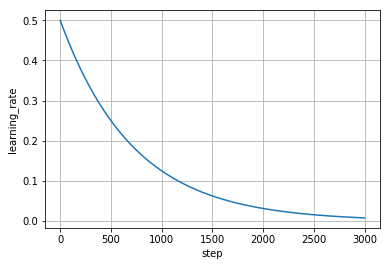

In [26]:
learning_rate = 0.5
decay_rate = 0.8
global_step = np.arange(3000)
decay_steps = 500.

decayed_learning_rate = learning_rate * decay_rate ** (global_step / decay_steps)

plot(global_step, decayed_learning_rate)
xlabel('step')
ylabel('learning_rate')
grid()

In [27]:

batch_size = 128
fc1_size = 1024
fc2_size = 512
fc3_size = 128

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.

    # Variables.
    # stddev is very important!!!
    W1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, fc1_size], stddev=np.sqrt(2.0 / (image_size * image_size))))
    b1 = tf.Variable(tf.zeros([fc1_size]))

    W2 = tf.Variable(tf.truncated_normal([fc1_size, fc2_size], stddev=np.sqrt(2.0 / fc1_size)))
    b2 = tf.Variable(tf.zeros([fc2_size]))

    W3 = tf.Variable(tf.truncated_normal([fc2_size, fc3_size], stddev=np.sqrt(2.0 / fc2_size)))
    b3 = tf.Variable(tf.zeros([fc3_size]))

    W4 = tf.Variable(tf.truncated_normal([fc3_size, num_labels], stddev=np.sqrt(2.0 / fc3_size)))
    b4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    y1 = tf.nn.dropout(y1, 0.5)

    y2 = tf.nn.relu(tf.matmul(y1, W2) + b2)
    y2 = tf.nn.dropout(y2, 0.5)

    y3 = tf.nn.relu(tf.matmul(y2, W3) + b3)
    y3 = tf.nn.dropout(y3, 0.5)

    logits = tf.matmul(y3, W4) + b4

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) +
                             tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) + tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4))

    # Optimizer
    learning_rate = tf.train.exponential_decay(1., global_step, 1000, 0.6, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    y2_valid = tf.nn.relu(tf.matmul(y1_valid, W2) + b2)
    y3_valid = tf.nn.relu(tf.matmul(y2_valid, W3) + b3)
    valid_logits = tf.matmul(y3_valid, W4) + b4
    valid_prediction = tf.nn.softmax(valid_logits)

    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    y2_test = tf.nn.relu(tf.matmul(y1_test, W2) + b2)
    y3_test = tf.nn.relu(tf.matmul(y2_test, W3) + b3)
    test_logits = tf.matmul(y3_test, W4) + b4
    test_prediction = tf.nn.softmax(test_logits)

In [29]:
# Let's run it:
num_steps = 10000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Final Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 4.791980
Minibatch accuracy: 8.6%
Validation accuracy: 18.6%
Minibatch loss at step 500: 1.363818
Minibatch accuracy: 83.6%
Validation accuracy: 83.0%
Minibatch loss at step 1000: 0.967974
Minibatch accuracy: 82.8%
Validation accuracy: 84.4%
Minibatch loss at step 1500: 0.738463
Minibatch accuracy: 88.3%
Validation accuracy: 85.7%
Minibatch loss at step 2000: 0.620019
Minibatch accuracy: 89.8%
Validation accuracy: 86.6%
Minibatch loss at step 2500: 0.639130
Minibatch accuracy: 85.2%
Validation accuracy: 87.1%
Minibatch loss at step 3000: 0.652855
Minibatch accuracy: 85.9%
Validation accuracy: 87.2%
Minibatch loss at step 3500: 0.681844
Minibatch accuracy: 85.2%
Validation accuracy: 87.6%
Minibatch loss at step 4000: 0.589561
Minibatch accuracy: 90.6%
Validation accuracy: 87.6%
Minibatch loss at step 4500: 0.628369
Minibatch accuracy: 88.3%
Validation accuracy: 87.7%
Minibatch

In [30]:
print learning_rate

SyntaxError: invalid syntax (<ipython-input-30-cc76082cf626>, line 1)